In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Akarshan/BERT")
!ls -l

total 462405
-rw------- 1 root root    207564 Dec 25 10:00 '2 SciBert400k.ipynb'
-rw------- 1 root root    208923 Dec 24 22:28 '3 SciBert400k.ipynb'
-rw------- 1 root root    233350 Dec 24 18:11 '4 SciBert400k.ipynb'
drwx------ 2 root root      4096 Dec  3 16:27  clr
-rw------- 1 root root    349041 Dec 24 18:32  Compare.ipynb
drwx------ 2 root root      4096 Dec  3 16:27  Data
-rw------- 1 root root   8306584 Dec 24 07:57  DBert1hk.hdf5
-rw------- 1 root root  12719136 Dec 24 07:57  DBert4hk.hdf5
-rw------- 1 root root    251068 Dec 18 07:30  Distllbert400000.ipynb
-rw------- 1 root root     97583 Dec 24 22:28 'EDA on results.ipynb'
drwx------ 2 root root      4096 Dec 18 07:14 'misc model'
-rw------- 1 root root     43839 Dec 24 17:19  model.png
drwx------ 2 root root      4096 Dec  3 16:27  papers
-rw------- 1 root root   8306584 Dec 19 08:56  Rbert4.hdf5
-rw------- 1 root root     86347 Dec 19 06:43  Roberta.ipynb
-rw------- 1 root root    208993 Dec 25 10:25  SciBert400k.ipynb
drw

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 25 10:26:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install pympler
!pip install tensorflow_addons

     |████████████████████████████████| 3.4 MB 9.4 MB/s 
     |████████████████████████████████| 895 kB 27.9 MB/s 
     |████████████████████████████████| 61 kB 427 kB/s 
     |████████████████████████████████| 596 kB 37.2 MB/s 
     |████████████████████████████████| 3.3 MB 28.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 164 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [ ]:
import numpy as np
import pickle
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pympler import asizeof
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import pipeline
from tensorflow.keras.layers import concatenate
from transformers import BertModel,BertTokenizer, TFAutoModel, AutoTokenizer, AutoConfig,TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
import tensorflow_addons as tfa

In [ ]:
csvfile = 'Data//data.csv'
dropna = 'Data//datadropna.csv'
sent_data_file = 'Data//sent_data.csv'
label_file = 'Data//label.csv'
vocab_file = 'Data//vocab_tr_w.txt'

In [ ]:
df = pd.read_csv(dropna,usecols = ['SBE','Label'])
# df.dropna(inplace=True)
print(df.head())
print(df.shape)

   Label                                                SBE
0      1  To facilitate an easier notation throughout th...
1      0  Therefore _MATH_ defines a special order of ti...
2      0  This is important since only _MATH_ is the rea...
3      0  Note that in all contour time-integrals we ess...
4      0  Theorem _REF_ proves the equivalence of ensemb...
(1189321, 2)


## Generating Embeddings

In [ ]:
# ! wget "https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/huggingface_pytorch/scibert_scivocab_uncased.tar"
# ! tar -xf scibert_scivocab_uncased.tar

In [ ]:
BERT = BertModel.from_pretrained("./scibert_scivocab_uncased")

tokenizer = BertTokenizer.from_pretrained("./scibert_scivocab_uncased",
                                          do_lower_case=True, 
                                          use_fast=True,
                                          max_length=128,
                                          truncation=True,
                                          pad_to_max_length=True)

pipe = pipeline('feature-extraction', model=BERT, 
                tokenizer=tokenizer)

Some weights of the model checkpoint at ./scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected toke

In [ ]:
batch=20
df = df.iloc[160000:200000,:]
step = int(df.shape[0]/batch)
step

2000

In [ ]:
#### getting embedding vectors as bert output ###
# pipe returns embeddings for every token in a sent 
# so features[x][0] is of shape (y,768) with y tokens in xth sentance
# taking the mean for y tokens give the embedding for the xth sent in total
# saving a batch of features as feature_matrix with 768 zeors as head 
import pickle
import time
count = 80
for part in range(batch):
  i = part+count
  strt = time.time()
  indx = step*part
  indy = step*(part+1)
  # print(indx,indy)
  feature_matrix = array = np.empty(768, dtype=object) 
  lst = []
  features = np.array(pipe(df['SBE'].iloc[indx:indy].to_list()))

  for idx in range(np.shape(features)[0]):
    sent_mean = np.mean(features[idx][0],axis =0)
    lst.append(sent_mean)
  # print(np.shape(lst))
  feature_matrix= np.array(lst)
  # print(np.shape(feature_matrix))
  # print(feature_matrix)
  
  with open('Data//embeddingSb//embeddings'+str(i),'wb') as f:
    pickle.dump(feature_matrix,f)
  
  print(f'Part {part+1} of {batch} done in {(time.time()-strt)/60:.2f} min')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Part 1 of 20 done in 3.68 min
Part 2 of 20 done in 4.25 min
Part 3 of 20 done in 3.50 min
Part 4 of 20 done in 3.28 min
Part 5 of 20 done in 3.38 min
Part 6 of 20 done in 3.30 min
Part 7 of 20 done in 3.24 min
Part 8 of 20 done in 3.25 min
Part 9 of 20 done in 2.98 min
Part 10 of 20 done in 2.96 min
Part 11 of 20 done in 2.96 min
Part 12 of 20 done in 3.00 min
Part 13 of 20 done in 2.99 min
Part 14 of 20 done in 2.93 min
Part 15 of 20 done in 2.96 min
Part 16 of 20 done in 3.07 min
Part 17 of 20 done in 3.42 min
Part 18 of 20 done in 3.29 min
Part 19 of 20 done in 3.27 min
Part 20 of 20 done in 3.23 min


In [ ]:
num = len(os.listdir('Data//embeddingSb//'))

with open('Data//embeddingSb//embeddings'+str(0),'rb') as f:
    dataS = pickle.load(f)
    
for idx in range(1,num):
    
  with open('Data//embeddingSb//embeddings'+str(idx),'rb') as f:
    mat = pickle.load(f)
    dataS=np.concatenate([dataS,mat],axis=0)

In [ ]:
np.shape(dataS)

(400000, 768)

In [ ]:
datay = df.iloc[:400000,:]

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(dataS, datay['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=datay['Label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_text, train_labels))
train_data = train_data.shuffle(5000).batch(128)


val_data = tf.data.Dataset.from_tensor_slices((val_text, val_labels))
val_data = val_data.shuffle(5000).batch(128)


In [ ]:
input = tf.keras.layers.Input(shape=(768,), name='input_token', dtype='int32')
X = tf.keras.layers.Dense(768, activation='relu')(input)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(2, activation='softmax')(X)
model = tf.keras.Model(inputs=input, outputs = X)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 768)               590592    
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               393728    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

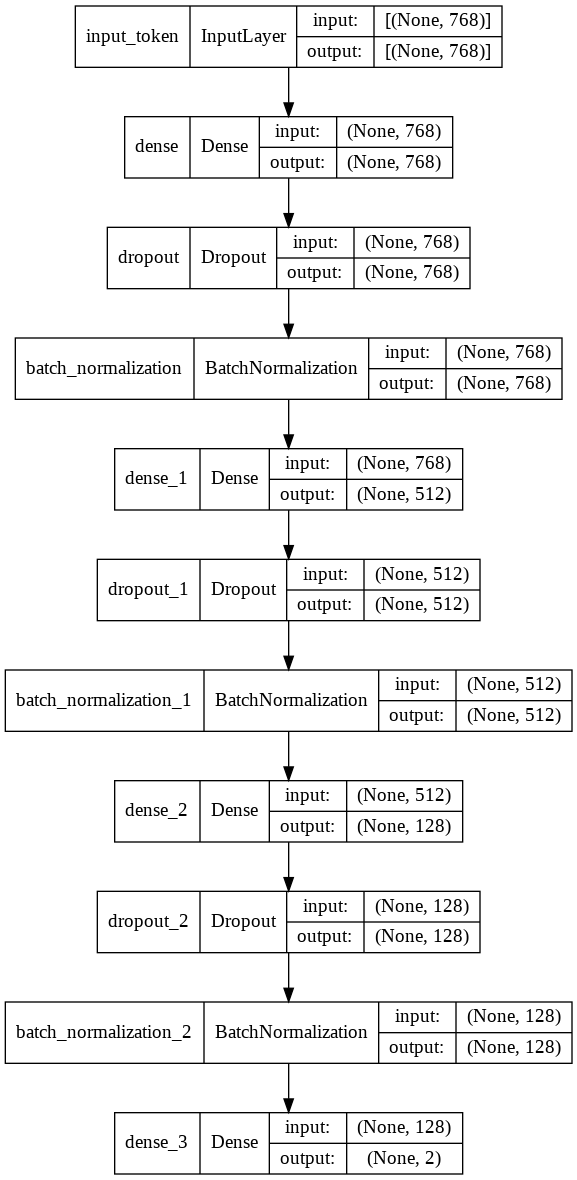

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
filepath="SBert.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True, mode='min')
ES =tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,verbose=1,mode="min",restore_best_weights=True)
# pre = tf.keras.metrics.Precision()
f1 = tfa.metrics.F1Score(num_classes=2, average="macro")
callbacks_list = [checkpoint,ES]
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=[f1])

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=30,verbose=1, callbacks = callbacks_list)

Epoch 1/30
8740/8750 [============================>.] - ETA: 0s - loss: 0.6416 - f1_score: 0.5651
Epoch 00001: val_loss improved from inf to 0.62894, saving model to SBert.hdf5
8750/8750 [==============================] - 47s 5ms/step - loss: 0.6416 - f1_score: 0.5651 - val_loss: 0.6289 - val_f1_score: 0.5406
Epoch 2/30
8745/8750 [============================>.] - ETA: 0s - loss: 0.6324 - f1_score: 0.5687
Epoch 00002: val_loss improved from 0.62894 to 0.62660, saving model to SBert.hdf5
8750/8750 [==============================] - 41s 5ms/step - loss: 0.6324 - f1_score: 0.5688 - val_loss: 0.6266 - val_f1_score: 0.5607
Epoch 3/30
8747/8750 [============================>.] - ETA: 0s - loss: 0.6301 - f1_score: 0.5732
Epoch 00003: val_loss improved from 0.62660 to 0.62623, saving model to SBert.hdf5
8750/8750 [==============================] - 41s 5ms/step - loss: 0.6301 - f1_score: 0.5732 - val_loss: 0.6262 - val_f1_score: 0.5756
Epoch 4/30
8740/8750 [============================>.] - ETA

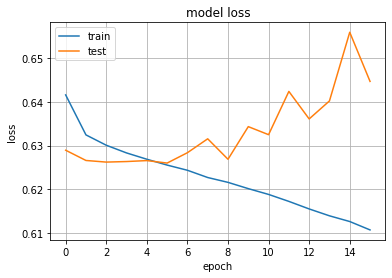

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.grid()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("SBert.hdf5")

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_text))
test_data = test_data.shuffle(5000).batch(128)

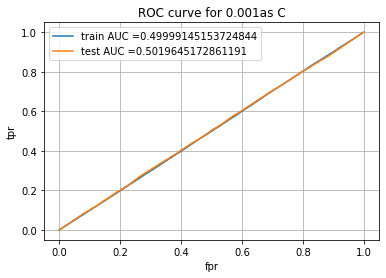

In [ ]:
y_pr_ts = model.predict(test_data)[:,0]
y_pred_tr = model.predict(train_data)[:,0]
y_ts = test_labels[:,0]
y_tr = train_labels[:,0]
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.25205766737743474 for threshold 0.712
train
the maximum value of tpr*(1-fpr) 0.24971582508754495 for threshold 0.713


Train Confusion Matrix


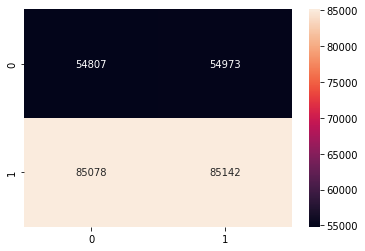

In [ ]:
print('Train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_tr, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


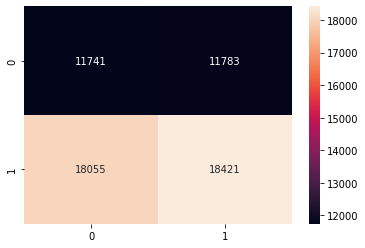

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 50.27%
Precision on test set: 60.99%
recall score on test set: 50.50%
f1 score on test set: 55.25%
